# [ Grafo ] Heurísticas computacionais para extração deconhecimento em problemas de maratona deprogramação - Parte 2 (PLN)

Após realizar o tratamento básico dos dados, é necessário realizar alguns passos básicos de Processamento de Linguagem Natural (PLN) a fim de poder fornecer os problemas como entrada para algum classificador.

### Importando as bibliotecas necessárias

Antes de começar, é necessário importar algumas bibliotecas para tratar os dados.

In [1]:
import os
import json
import nltk
import scipy
import graphviz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from nltk.corpus import stopwords
from scipy.spatial import distance

### Declarando constantes de trabalho

Criação de "variáveis de ambiente" para auxiliar a obtenção de dados.

In [2]:
# Langs? {PT, EN, ES}
LANG_SLUG = "EN"
GRAPHS_OUTPUT_DIR = "../Graphs/"
PREPROCESSED_DATA_DIR = "../Datasets/"

# Preprocessed files {%LANG_00_raw_data, %LANG_01_primary_data, %LANG_02_secondary_data, %LANG_03_terciary_data}.csv
PREPROCESSED_FILE = "%s%s%s" % (PREPROCESSED_DATA_DIR, LANG_SLUG, "_03_terciary_data.csv")

### Tokenização

Aqui os textos de descrição, entrada e saída serão tokenizados (extraídos as palavras)

In [3]:
# Lê o arquivo CSV e trata os objetos vazios
rawDataDF = pd.read_csv(PREPROCESSED_FILE, sep=";", index_col = 0)
rawDataDF.fillna("", inplace = True)

# Tokeniza os textos do problema
tokenized = pd.DataFrame()
tokenized["problem"] = rawDataDF.apply(lambda x : nltk.word_tokenize(x["description"]), axis = 1)
tokenized["in"] = rawDataDF.apply(lambda x : nltk.word_tokenize(x["input"]), axis = 1)
tokenized["out"] = rawDataDF.apply(lambda x : nltk.word_tokenize(x["output"]), axis = 1)

# Converte todas as letras para "minúsculas"
tokenized["problem"] = tokenized.apply(lambda x: [w.lower() for w in x["problem"]], axis = 1)
tokenized["in"] = tokenized.apply(lambda x: [w.lower() for w in x["in"]], axis = 1)
tokenized["out"] = tokenized.apply(lambda x: [w.lower() for w in x["out"]], axis = 1)

# Imprime parte do DF
tokenized.head()

,problem,in,out
1001,"[read, 2, variables, ,, named, a, and, b, and,...","[the, input, file, will, contain, 2, integer, ...","[print, the, letter, x, (, uppercase, ), with,..."
1002,"[the, formula, to, calculate, the, area, of, a...","[the, input, contains, a, value, of, floating,...","[present, the, message, ``, a=, '', followed, ..."
1003,"[read, two, integer, values, ,, in, this, case...","[the, input, file, contains, 2, integer, numbe...","[print, the, variable, soma, with, all, the, c..."
1004,"[read, two, integer, values, ., after, this, ,...","[the, input, file, contains, 2, integer, numbe...","[print, prod, according, to, the, following, e..."
1005,"[read, two, floating, points, ', values, of, d...","[the, input, file, contains, 2, floating, poin...","[print, media, (, average, in, portuguese, ), ..."


### Remoção de stopwords

Remoção de stopwords e limpeza de caracteres (remoção de palavras não alfanuméricas) com o auxílio do NLTK

In [4]:
stoplist = stopwords.words('english')

tokenized["problem"] = tokenized.apply(lambda x: [w for w in x["problem"] if (w not in stoplist and w.isalpha())], axis = 1)
tokenized["in"] = tokenized.apply(lambda x: [w for w in x["in"] if (w not in stoplist and w.isalpha())], axis = 1)
tokenized["out"] = tokenized.apply(lambda x: [w for w in x["out"] if (w not in stoplist and w.isalpha())], axis = 1)

# Imprime parte do DF
tokenized.head()

,problem,in,out
1001,"[read, variables, named, b, make, sum, two, va...","[input, file, contain, integer, numbers]","[print, letter, x, uppercase, blank, space, eq..."
1002,"[formula, calculate, area, circumference, defi...","[input, contains, value, floating, point, doub...","[present, message, followed, value, variable, ..."
1003,"[read, two, integer, values, case, variables, ...","[input, file, contains, integer, numbers]","[print, variable, soma, capital, letters, blan..."
1004,"[read, two, integer, values, calculate, produc...","[input, file, contains, integer, numbers]","[print, prod, according, following, example, b..."
1005,"[read, two, floating, points, values, double, ...","[input, file, contains, floating, points, valu...","[print, media, average, portuguese, according,..."


### Aplicação de tag - Part Of Speech (POS)

Aplicação de POS tags utilizando a NLTK

In [5]:
# Aplica o POS_TAG
tagged = pd.DataFrame()
tagged["problem"] = tokenized.apply(lambda x: nltk.pos_tag(x["problem"]), axis = 1)
tagged["in"] = tokenized.apply(lambda x: nltk.pos_tag(x["in"]), axis = 1)
tagged["out"] = tokenized.apply(lambda x: nltk.pos_tag(x["out"]), axis = 1)

# Imprime parte do DF
tagged.head()

,problem,in,out
1001,"[(read, JJ), (variables, NNS), (named, VBN), (...","[(input, NN), (file, NN), (contain, NN), (inte...","[(print, NN), (letter, NN), (x, NNP), (upperca..."
1002,"[(formula, NN), (calculate, NN), (area, NN), (...","[(input, NN), (contains, VBZ), (value, NN), (f...","[(present, JJ), (message, NN), (followed, VBD)..."
1003,"[(read, VB), (two, CD), (integer, JJR), (value...","[(input, NN), (file, NN), (contains, VBZ), (in...","[(print, NN), (variable, JJ), (soma, NN), (cap..."
1004,"[(read, VB), (two, CD), (integer, JJR), (value...","[(input, NN), (file, NN), (contains, VBZ), (in...","[(print, NN), (prod, NN), (according, VBG), (f..."
1005,"[(read, VB), (two, CD), (floating, VBG), (poin...","[(input, NN), (file, NN), (contains, VBZ), (fl...","[(print, NN), (media, NNS), (average, JJ), (po..."


### Aplicação do Lemmatizador

Conversão das palavras para suas formas inflexionadas utilizando o WordNetLemmatizer. **Ex.:** "following" -> "follow".

Caso o idioma escolhido seja o português, deve-se utilizar algum lemmatizador alternativo ou então o próprio stemmer para a língua portuguesa disponível na NLTK.

In [6]:
# Convert POS to WordNet POS
# From https://www.machinelearningplus.com/nlp/lemmatization-examples-python/#wordnetlemmatizer
def to_wn_pos(tagged_word):
    tag_dict = {"J" : nltk.corpus.wordnet.ADJ,
                "N" : nltk.corpus.wordnet.NOUN,
                "V" : nltk.corpus.wordnet.VERB,
                "R" : nltk.corpus.wordnet.ADV}
    return tag_dict.get(tagged_word[1][0].upper(), nltk.wordnet.NOUN)

# Aplica a lemmatização
lemmatizer = nltk.stem.WordNetLemmatizer()

lemmatized = pd.DataFrame()
lemmatized["problem"] = tagged.apply(lambda x: [(lemmatizer.lemmatize(tup[0], to_wn_pos(tup)), tup[1]) for tup in x["problem"]], axis = 1)
lemmatized["in"] = tagged.apply(lambda x: [(lemmatizer.lemmatize(tup[0], to_wn_pos(tup)), tup[1]) for tup in x["in"]], axis = 1)
lemmatized["out"] = tagged.apply(lambda x: [(lemmatizer.lemmatize(tup[0], to_wn_pos(tup)), tup[1]) for tup in x["out"]], axis = 1)

# Imprime parte do DF
lemmatized.head()

,problem,in,out
1001,"[(read, JJ), (variable, NNS), (name, VBN), (b,...","[(input, NN), (file, NN), (contain, NN), (inte...","[(print, NN), (letter, NN), (x, NNP), (upperca..."
1002,"[(formula, NN), (calculate, NN), (area, NN), (...","[(input, NN), (contain, VBZ), (value, NN), (fl...","[(present, JJ), (message, NN), (follow, VBD), ..."
1003,"[(read, VB), (two, CD), (integer, JJR), (value...","[(input, NN), (file, NN), (contain, VBZ), (int...","[(print, NN), (variable, JJ), (soma, NN), (cap..."
1004,"[(read, VB), (two, CD), (integer, JJR), (value...","[(input, NN), (file, NN), (contain, VBZ), (int...","[(print, NN), (prod, NN), (accord, VBG), (foll..."
1005,"[(read, VB), (two, CD), (float, VBG), (point, ...","[(input, NN), (file, NN), (contain, VBZ), (flo...","[(print, NN), (medium, NNS), (average, JJ), (p..."


### Análise de POS tagging nos problemas por categoria

A seguir, são analisadas as POS tags de cada grupo de problemas (de acordo com as classificações WordNet - para simplificar)

Category :  Beginner


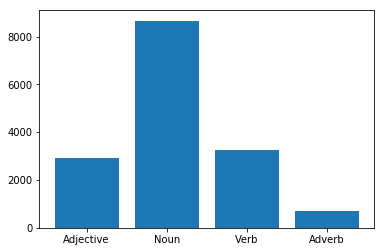

Category :  Data Structures and Libraries


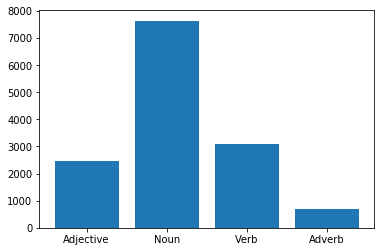

Category :  Strings


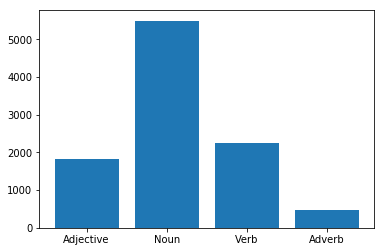

Category :  Ad-Hoc


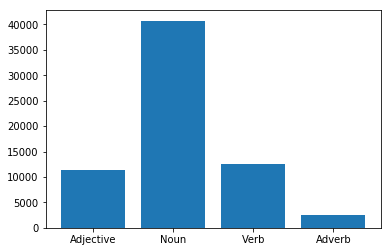

Category :  Paradigms


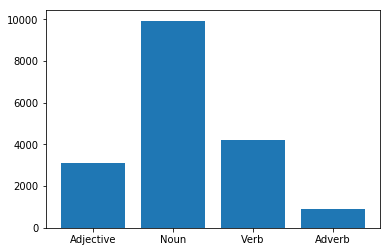

Category :  Mathematics


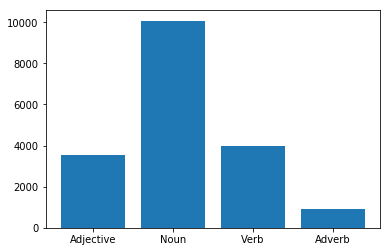

Category :  Computational Geometry


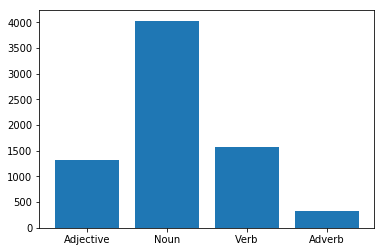

Category :  Graph


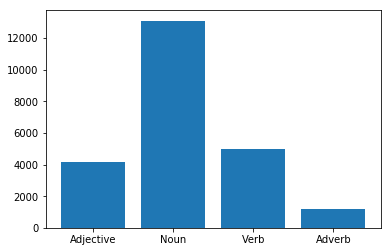

In [7]:
def count_pos_elements(row, d):
    for val in row["problem"]:
        d[to_wn_pos(val)] = d[to_wn_pos(val)] + 1

categories = rawDataDF["category"].unique()

for cat in categories:
    count = {
        nltk.corpus.wordnet.ADJ : 0,
        nltk.corpus.wordnet.NOUN : 0,
        nltk.corpus.wordnet.VERB : 0,
        nltk.corpus.wordnet.ADV : 0
    }
    
    lemmatized.loc[rawDataDF[rawDataDF["category"] == cat].index].apply(lambda x : count_pos_elements(x, count), axis = 1)
    
    plt.bar(range(len(count)), list(count.values()), align = "center")
    plt.xticks(range(len(count)), ["Adjective" if pos_t == 'a' else "Noun" if pos_t == 'n' else "Verb" if pos_t == 'v' else "Adverb" for pos_t in count.keys()])
    
    print("Category : ", cat)
    plt.show()

### Geração da matriz termo-documento

Como o objetivo deste trabalho é realizar a comparação entre a semântica dos problemas, então, torna-se mais viável tratar os problemas como sendo as linhas da matriz e as palavras (termos) como sendo as colunas (para possíveis fins de compactação posterior). **ATENÇÃO:** Por motivos de desempenho, as linhas da matriz termo-documento serão compostas pelo vocabulário e as colunas pelos problemas. Caso seja necessário, basta obter o DF transposto.

#### Análise do vocabulário

In [8]:
# Vocabulário dos problemas, entrada e saída
vocab = {
    "problem" : set([]),
    "in" : set([]),
    "out" : set([])
}

lemmatized.apply(lambda x : vocab["problem"].update(set([[] if a == [] else a[0] for a in x["problem"]])), axis = 1)
lemmatized.apply(lambda x : vocab["in"].update(set([[] if a == [] else a[0] for a in x["in"]])), axis = 1)
lemmatized.apply(lambda x : vocab["out"].update(set([[] if a == [] else a[0] for a in x["out"]])), axis = 1)

# Dimensões do dicionário de vocabulários
print("Vocabulary dict shape :")
print(len(vocab["problem"]), len(vocab["in"]), len(vocab["out"]))
print("\nProblems (first ones):")
print(list(vocab["problem"])[:10])
print("\nInput (first ones):")
print(list(vocab["in"])[:10])
print("\nOutput (first ones):")
print(list(vocab["out"])[:10])

Vocabulary dict shape :
14252 4559 3931

Problems (first ones):
['presume', 'recurrence', 'pana', 'preferred', 'x', 'communication', 'valero', 'kantorovich', 'slice', 'pobekolas']

Input (first ones):
['dividend', 'elapse', 'shooter', 'x', 'relative', 'vânia', 'forward', 'genealogy', 'β', 'slice']

Output (first ones):
['og', 'elapse', 'testis', 'x', 'relative', 'communication', 'encaixa', 'slice', 'own', 'predict']


#### Construção, efetiva, da matriz

In [9]:
# Procedimento definido para preencher a "matriz" termo-documento
def parse_matrix_rows(row):
    column = str(row.name)
    problem_document_term_mat[column] = 0
    in_document_term_mat[column] = 0
    out_document_term_mat[column] = 0
    
    for tup in row["problem"]:
        problem_document_term_mat[column].loc[tup[0]] += 1
    for tup in row["in"]:
        in_document_term_mat[column].loc[tup[0]] += 1
    for tup in row["out"]:
        out_document_term_mat[column].loc[tup[0]] += 1
    


problem_document_term_mat = pd.DataFrame(index = vocab["problem"])
in_document_term_mat = pd.DataFrame(index = vocab["in"])
out_document_term_mat = pd.DataFrame(index = vocab["out"])

# Construção da "matriz" termo-documento (ou documento-termo)
lemmatized.apply(parse_matrix_rows, axis = 1)

# Imprime as dimensões das matrizes
print("\nProblems: ", problem_document_term_mat.shape)
print("\nInput: ", in_document_term_mat.shape)
print("\nOutput: ", out_document_term_mat.shape)
print("\n\n")

# Imprime parte do df de problemas
problem_document_term_mat.head()


Problems:  (14252, 1833)

Input:  (4559, 1833)

Output:  (3931, 1833)





,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,...,2952,2953,2954,2955,2956,2957,2958,2959,2960,2961
presume,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
recurrence,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pana,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
preferred,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
x,2,0,0,0,0,0,0,0,0,0,...,0,0,0,2,17,0,0,0,0,0


##### Conversão da matriz

A fim de agilizar o processo de geração dos grafos, converter-se-á o DataFrame em dois dicionários cujas chaves serão os problemas para o primeiro e as palavras para o segundo, que deverão apontar para os seus respectivos vetores.

In [21]:
word_document_term_dict = dict()
in_document_term_dict = dict()
out_document_term_dict = dict()
problem_document_term_dict = dict()

words_i = problem_document_term_mat.index
problems_i = problem_document_term_mat.columns

for word in words_i:
    word_document_term_dict[word] = problem_document_term_mat.loc[word].values

for problem in problems_i:
    in_document_term_dict[problem] = in_document_term_mat[problem].values
    out_document_term_dict[problem] = out_document_term_mat[problem].values
    problem_document_term_dict[problem] = problem_document_term_mat[problem].values

##### Vetores termo

In [22]:
word_document_term_dict

{'presume': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 'recurrence': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 'pana': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 'preferred': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 'x': array([2, 0, 0, ..., 0, 0, 0], dtype=int64),
 'communication': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 'valero': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 'kantorovich': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 'slice': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 'pobekolas': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 'conversam': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 'delas': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 'countless': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 'brasileira': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 'discs': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 'predict': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 'inteligentes': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 'fifty': array([0

##### Vetores documento

In [23]:
problem_document_term_dict

{'1001': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 '1002': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 '1003': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 '1004': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 '1005': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 '1006': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 '1007': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 '1008': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 '1009': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 '1010': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 '1011': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 '1012': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 '1013': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 '1014': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 '1015': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 '1016': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 '1017': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 '1018': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 '1019': array([0, 0, 0, ...

### Geração do grafo de similaridade semântica (entre problemas)

Para a análise de similaridade entre textos, dever-se-á calcular a distância entre os vetores-coluna da matriz. Neste caso, será utilizada a distância do cosseno que, convenientemente, já é normalizada (a função cosseno só retorna valores entre -1 e 1, sendo que, como todos os vetores só posssuem valores positivos, ela retornará valores entre 0 e 1).

\begin{equation}
    cosdist = 1 - \frac{v_1 \cdot v_2}{|v_1| |v_2|}
\end{equation}

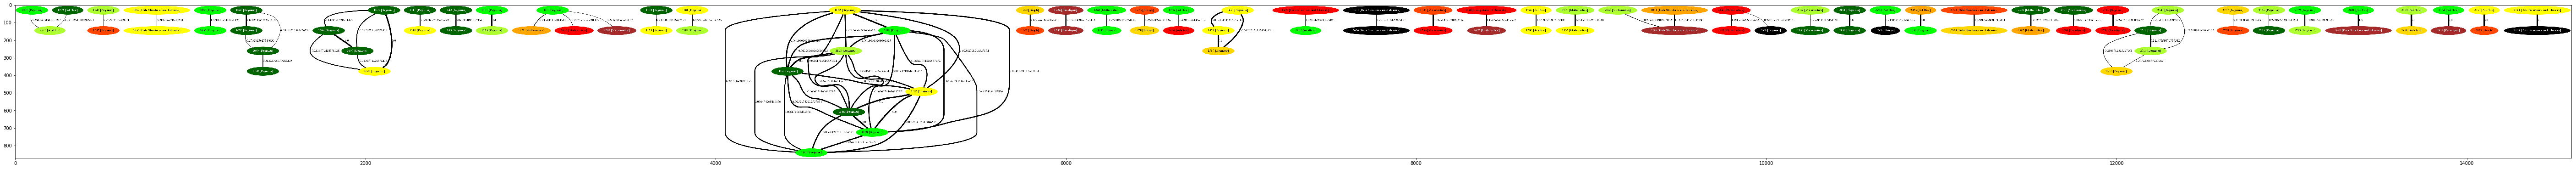

In [15]:
# Retorna a cor do vértice (e do texto) de acordo com a dificuldade
def vertex_colour(problem):
    colours = {
        1 : ("darkgreen", "white"),
        2 : ("green", "black"),
        3 : ("greenyellow", "black"),
        4 : ("yellow", "black"),
        5 : ("gold", "black"),
        6 : ("orange", "black"),
        7 : ("orangered", "black"),
        8 : ("red", "black"),
        9 : ("brown", "white"),
        10 : ("black", "white")
    }
    return colours.get(rawDataDF["level"].loc[int(problem)], ("gray", "black"))

# Calcula a distância do cosseno entre os problemas
# Quanto mais próximo de 1 (pela função da biblioteca), mais distantes estão entre si

added_vertex = []
# A seguinte linha já vem do passo anterior
# problems_i = problem_document_term_mat.columns
graph_path = "%s%s_%s" % (GRAPHS_OUTPUT_DIR, LANG_SLUG, "problems_co-ocurrence_problems_graph.gv")
graph = graphviz.Graph(name = "Co-ocurrence graph (problems)", filename = graph_path, format = "png",
                      node_attr = {'style' : 'filled'})

# A relação só é adicionada ao grafo se possuir mais de 70% de semelhança

for index_n, problem_i in enumerate(problems_i):
    for s_problem_i in problems_i[index_n + 1 : len(problems_i) - 1]:
        dist = distance.cosine(problem_document_term_dict[problem_i], problem_document_term_dict[s_problem_i])
        if dist < 0.3 :
            if problem_i not in added_vertex:
                v_colours = vertex_colour(problem_i)
                graph.node(problem_i,
                           label = "%s [%s]" % (problem_i, rawDataDF["category"].loc[int(problem_i)]),
                           _attributes = {'fillcolor' : v_colours[0], 'color' : v_colours[0], 'fontcolor' : v_colours[1]})
                added_vertex.append(problem_i)
            if s_problem_i not in added_vertex:
                v_colours = vertex_colour(s_problem_i)
                graph.node(s_problem_i,
                           label = "%s [%s]" % (s_problem_i, rawDataDF["category"].loc[int(s_problem_i)]),
                           _attributes = {'fillcolor' : v_colours[0], 'color' : v_colours[0], 'fontcolor' : v_colours[1]})
                added_vertex.append(s_problem_i)
            graph.edge(problem_i, s_problem_i, label = str(dist),
                       _attributes = {'style' : "setlinewidth(%f)" % (6 - dist * 16.66666), 'weight' : str(int(6 - dist * 16.66666))})

plt.figure(figsize=(100,100))
plt.imshow(mpimg.imread(graph.render()))
plt.show()

#### Considerando entrada e saída

Também é possível considerar os textos de entrada e saída dos problemas. Porém, como o vocabulário destas partes é bem menor que o vocabulário da descrição, estes textos devem ser "penalizados", tendo importância diretamente proporcional ao tamanho do vocabulário. Para tal, utilizam-se a seguinte fórmulas para o cálculo da distância:

**Peso total**:

\begin{equation}
    max = size(prob\_vocab) + size(in\_vocab) + size(out\_vocab) \\
\end{equation}

**Peso relativo de cada item**:

\begin{equation}
    in\_weight = \frac{size(in_vocab)}{max} \\
    out\_weight = \frac{size(out\_vocab)}{max} \\
    prob\_weight = 1 - (in\_weight + out\_weight)
\end{equation}

**Distância**:

\begin{equation}
    distance = cosdist(prob1, prob2) \cdot prob\_weight + cosdist(in1, in2) \cdot in\_weight + cosdist(out1, out2) \cdot out\_weight
\end{equation}

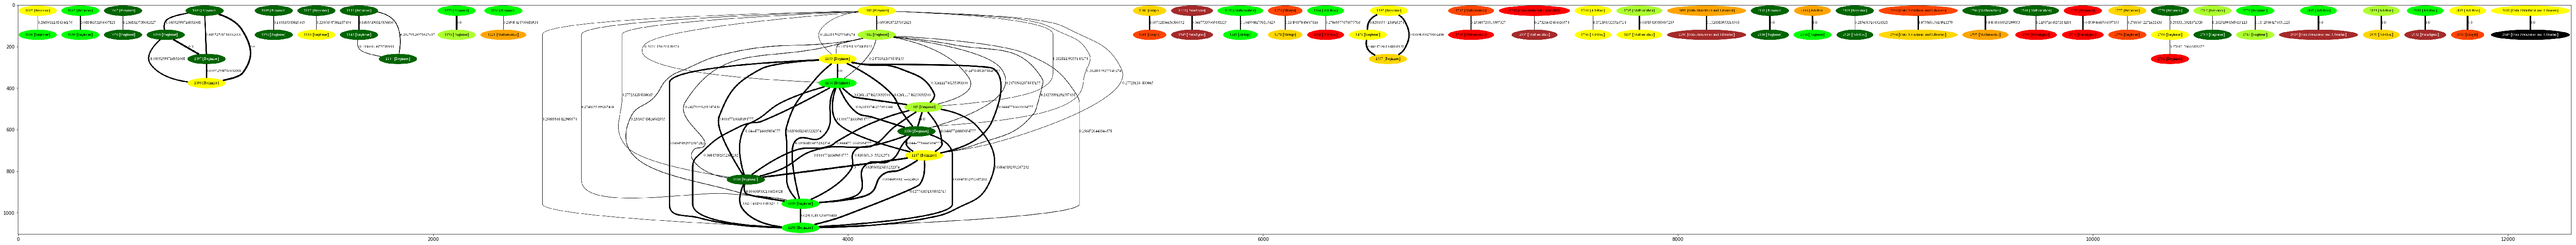

In [25]:
# Criação das constantes de ponderamento
full_weight = len(vocab["problem"]) + len(vocab["in"]) + len(vocab["out"])

in_weight = len(vocab["in"]) / full_weight
out_weight = len(vocab["out"]) / full_weight
prob_weight = 1 - (in_weight + out_weight)

# Criação do grafo
added_vertex = []
# A seguinte linha já vem do passo anterior
# problems_i = problem_document_term_mat.columns
graph_path = "%s%s_%s" % (GRAPHS_OUTPUT_DIR, LANG_SLUG, "problems_co-ocurrence_problems_in_out_graph.gv")
graph = graphviz.Graph(name = "Co-ocurrence graph (problems_in_out)", filename = graph_path, format = "png",
                      node_attr = {'style' : 'filled'})

for index_n, problem_i in enumerate(problems_i):
    for s_problem_i in problems_i[index_n + 1 : len(problems_i) - 1]:
        dist = distance.cosine(in_document_term_dict[problem_i], in_document_term_dict[s_problem_i]) * in_weight
        dist += distance.cosine(out_document_term_dict[problem_i], out_document_term_dict[s_problem_i]) * out_weight
        dist += distance.cosine(problem_document_term_dict[problem_i], problem_document_term_dict[s_problem_i]) * prob_weight
        if dist < 0.3 :
            if problem_i not in added_vertex:
                v_colours = vertex_colour(problem_i)
                graph.node(problem_i,
                           label = "%s [%s]" % (problem_i, rawDataDF["category"].loc[int(problem_i)]),
                           _attributes = {'fillcolor' : v_colours[0], 'color' : v_colours[0], 'fontcolor' : v_colours[1]})
                added_vertex.append(problem_i)
            if s_problem_i not in added_vertex:
                v_colours = vertex_colour(s_problem_i)
                graph.node(s_problem_i,
                           label = "%s [%s]" % (s_problem_i, rawDataDF["category"].loc[int(s_problem_i)]),
                           _attributes = {'fillcolor' : v_colours[0], 'color' : v_colours[0], 'fontcolor' : v_colours[1]})
                added_vertex.append(s_problem_i)
            graph.edge(problem_i, s_problem_i, label = str(dist),
                       _attributes = {'style' : "setlinewidth(%f)" % (6 - dist * 16.66666), 'weight' : str(int(6 - dist * 16.66666))})

plt.figure(figsize=(100,100))
plt.imshow(mpimg.imread(graph.render()))
plt.show()

#### Distância entre as palavras

Assim como foi calculado a distância entre os problemas, também é possível identificar a similaridade semântica das palavras neles presentes. Para tal, basta calcular a similaridade do cosseno entre as linhas da matriz.

In [ ]:
# Calcula a distância do cosseno entre as palavras
# Quanto mais próximo de 1 (pela função da biblioteca), mais distantes estão entre si

added_vertex = []
# A seguinte linha já vem do passo anterior
# words_i = problem_document_term_mat.index
graph_path = "%s%s_%s" % (GRAPHS_OUTPUT_DIR, LANG_SLUG, "words_co-ocurrence_words_graph.gv")
graph = graphviz.Graph(name = "Co-ocurrence graph (words)", filename = graph_path, format = "png",
                      node_attr = {'style' : 'filled'})

# A relação só é adicionada ao grafo se possuir mais de 70% de semelhança

for index_n, word_i in enumerate(words_i):
    for s_word_i in words_i[index_n + 1 : len(words_i) - 1]:
        dist = distance.cosine(word_document_term_dict[word_i], word_document_term_dict[s_word_i])
        if dist < 0.2 :
            if word_i not in added_vertex:
                v_colours = ("black", "white")
                graph.node(word_i,
                           label = word_i,
                           _attributes = {'fillcolor' : v_colours[0], 'color' : v_colours[0], 'fontcolor' : v_colours[1]})
                added_vertex.append(word_i)
            if s_word_i not in added_vertex:
                v_colours = ("black", "white")
                graph.node(s_word_i,
                           label = s_word_i,
                           _attributes = {'fillcolor' : v_colours[0], 'color' : v_colours[0], 'fontcolor' : v_colours[1]})
                added_vertex.append(s_word_i)
            graph.edge(word_i, s_word_i, label = str(dist),
                       _attributes = {'style' : "setlinewidth(%f)" % (6 - dist * 16.66666), 'weight' : str(int(6 - dist * 16.66666))})

plt.figure(figsize=(100,100))
plt.imshow(mpimg.imread(graph.render()))
plt.show()